In [36]:
from live_wire import load_image
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np
from skimage.filters import gaussian, sato
from skimage.feature import canny
from skimage.graph import route_through_array
from skimage.filters import frangi
from skimage.morphology import skeletonize

In [72]:
## NO LONGER INVERSE (NOT 1/...)
def compute_cost(image, sigma=1.0, epsilon=1e-1):
    """
    Smooth the image, run Canny edge detection, then invert the edge map into a cost image.
    """

    smoothed_img = gaussian(image, sigma=sigma)
    canny_img = sato(smoothed_img)

    canny_thresh = canny_img > 0.05

    skeleton = skeletonize(canny_thresh)

    cost_img = 1 /(skeleton + epsilon)  # Invert edges: higher cost where edges are stronger
    return cost_img, canny_img

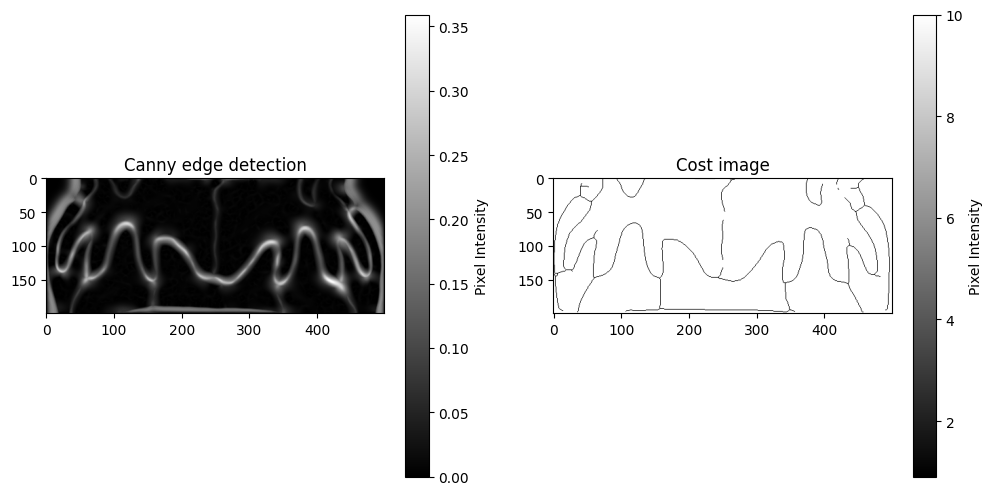

In [73]:
image = load_image('new_image.png', 'gray')

cost_img, canny_img = compute_cost(image)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(canny_img, cmap='gray')
plt.title('Canny edge detection')
plt.colorbar(label='Pixel Intensity')

plt.subplot(1, 2, 2)
plt.imshow(cost_img, cmap='gray')
plt.title('Cost image')
plt.colorbar(label='Pixel Intensity')

plt.show()


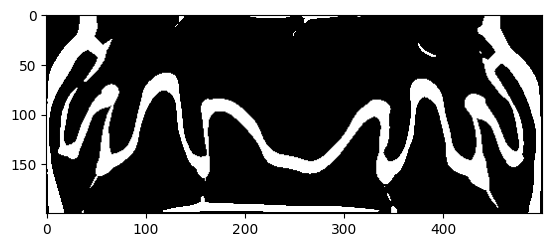

In [81]:
canny_thresh = canny_img > 0.08

plt.imshow(canny_thresh, cmap='gray')

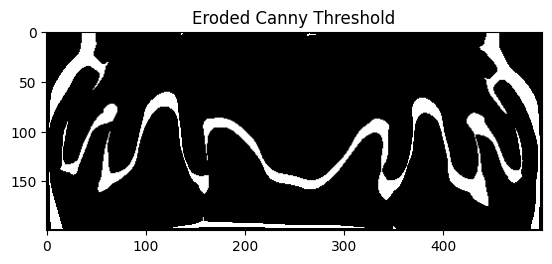

In [86]:
from scipy.ndimage import binary_erosion

eroded_canny_thresh = binary_erosion(canny_thresh, structure=np.ones((4,4)))

plt.imshow(eroded_canny_thresh, cmap='gray')
plt.title('Eroded Canny Threshold')
plt.show()

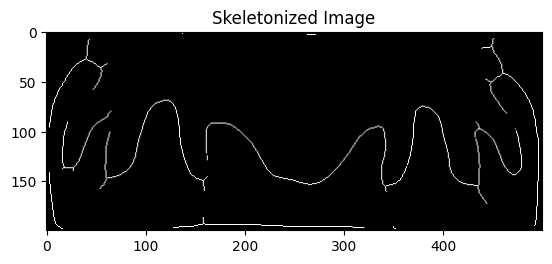

In [88]:
from skimage.morphology import skeletonize

skeleton = skeletonize(eroded_canny_thresh)

plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonized Image')
plt.show()

## DISK TEST

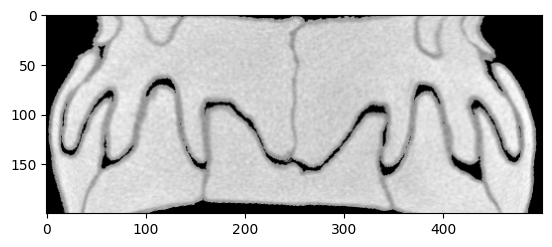

In [91]:
image = load_image('agamodon_slice.png', 'gray')
plt.imshow(image, cmap='gray')

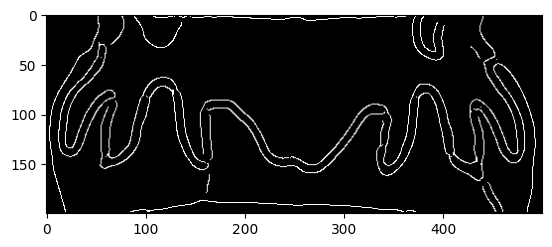

In [94]:
canny_img = canny(gaussian(image, sigma=3), sigma=1.0)
plt.imshow(canny_img, cmap='gray')

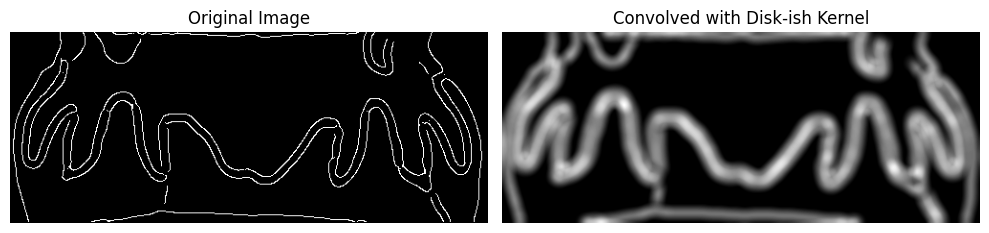

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.signal import convolve2d

# Load a sample image; replace this with your own
image = canny_img

# Define kernel size (odd number preferred)
k_size = 21

# Calculate the radius (half of k_size)
radius = (k_size - 1) / 2.0

# Create a coordinate grid for the kernel
Y, X = np.ogrid[:k_size, :k_size]

# Compute distance from the kernel's center for each point
dist_from_center = np.sqrt((X - radius)**2 + (Y - radius)**2)

# Create disk-ish weights:
#   At the center (distance = 0) -> 1,
#   Decreasing linearly to 0 at the boundary of the disk
kernel = np.maximum(0, 1 - dist_from_center / radius)

# Normalize so the kernel sums to 1
kernel /= kernel.sum()

# Convolve the image with this disk-ish kernel
convolved_image = convolve2d(image, kernel, mode='same', boundary='symm')

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(convolved_image, cmap='gray')
ax2.set_title('Convolved with Disk-ish Kernel')
ax2.axis('off')

plt.tight_layout()
plt.show()


In [99]:
import numpy as np

def circle_edge_kernel(k_size=5, radius=None):
    """
    Create a k_size x k_size array whose values increase linearly
    from 0 at the center to 1 at the circle boundary (radius).

    Parameters
    ----------
    k_size : int
        The size (width and height) of the kernel array.
    radius : float, optional
        The circle's radius. By default, set to (k_size-1)/2.

    Returns
    -------
    kernel : 2D numpy array of shape (k_size, k_size)
        The circle-edge-weighted kernel.
    """
    if radius is None:
        # By default, let the radius be half the kernel size
        radius = (k_size - 1) / 2

    # Create an empty kernel
    kernel = np.zeros((k_size, k_size), dtype=float)

    # Coordinates of the center
    center = radius  # same as (k_size-1)/2 if radius is default

    # Fill the kernel
    for y in range(k_size):
        for x in range(k_size):
            dist = np.sqrt((x - center)**2 + (y - center)**2)
            if dist <= radius:
                # Weight = distance / radius => 0 at center, 1 at boundary
                kernel[y, x] = dist / radius

    return kernel


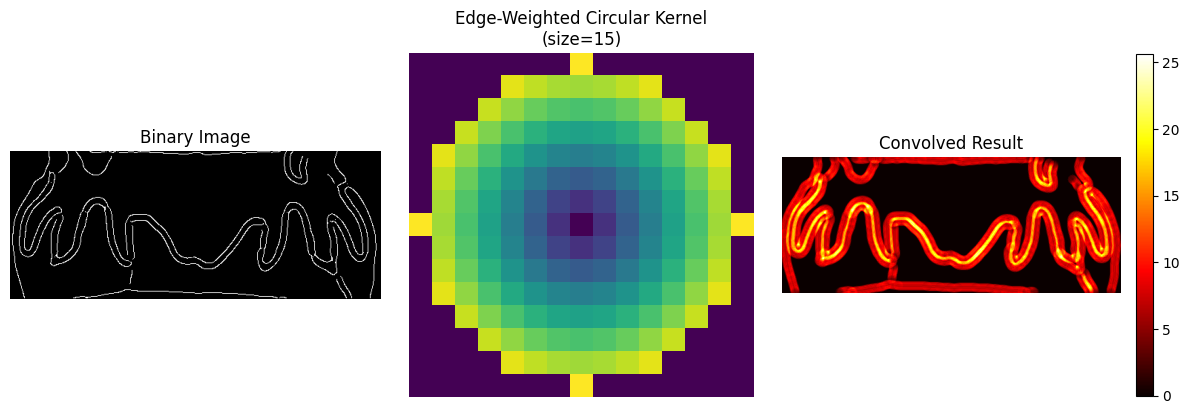

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# 1) Create a simple binary image
binary_img = canny_img

# 2) Create the edge-weighted circular kernel
k_size = 15
kernel = circle_edge_kernel(k_size=k_size)

# 3) Convolve the binary image with the kernel
# mode='same' => output is the same size as the image
convolved = convolve2d(binary_img, kernel, mode='same', boundary='fill')

# 4) Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(binary_img, cmap='gray')
axes[0].set_title("Binary Image")
axes[0].axis('off')

axes[1].imshow(kernel, cmap='viridis')
axes[1].set_title("Edge-Weighted Circular Kernel\n(size={})".format(k_size))
axes[1].axis('off')

im = axes[2].imshow(convolved, cmap='hot')
axes[2].set_title("Convolved Result")
axes[2].axis('off')

plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


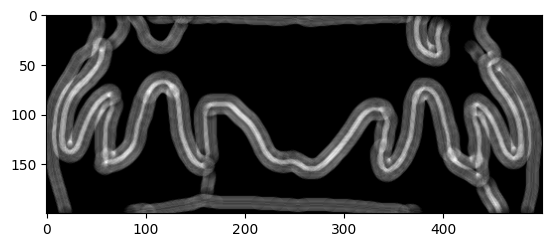

In [110]:
plt.imshow(convolved, cmap='gray')

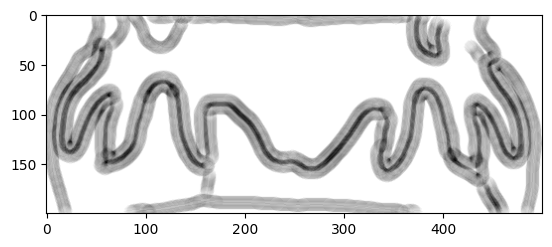

In [114]:
cost_img = - convolved

plt.imshow(cost_img, cmap='gray')